<a href="https://colab.research.google.com/github/kwokchunghim/Sentiment-Classification/blob/main/SemEval_2017_(Task_4).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Import necessary packages
You may import more packages here.

In [ ]:
#Run this cell only when using colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Import necessary packages
import re
import os
import copy
from os.path import join
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem.porter import *
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from collections import defaultdict
from nltk import pos_tag
from sklearn.svm import SVC
import random
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import torch
import torch.nn as nn
import torchtext
from torchtext import data
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import TensorDataset, DataLoader, Dataset
import transformers
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#Set current working directory to '/content/drive/MyDrive/CS918 Assignment 2'
os.chdir('/content/drive/MyDrive/CS918 Assignment 2')

In [ ]:
# Define test sets
testsets = ['twitter-test1.txt', 'twitter-test2.txt', 'twitter-test3.txt']

In [ ]:
# Skeleton: Evaluation code for the test sets
def read_test(testset):
    '''
    readin the testset and return a dictionary
    :param testset: str, the file name of the testset to compare
    '''
    id_gts = {}
    with open(testset, 'r', encoding='utf8') as fh:
        for line in fh:
            fields = line.split('\t')
            tweetid = fields[0]
            gt = fields[1]

            id_gts[tweetid] = gt

    return id_gts


def confusion(id_preds, testset, classifier):
    '''
    print the confusion matrix of {'positive', 'negative'} between preds and testset
    :param id_preds: a dictionary of predictions formated as {<tweetid>:<sentiment>, ... }
    :param testset: str, the file name of the testset to compare
    :classifier: str, the name of the classifier
    '''
    id_gts = read_test(testset)

    gts = []
    for m, c1 in id_gts.items():
        if c1 not in gts:
            gts.append(c1)

    gts = ['positive', 'negative', 'neutral']

    conf = {}
    for c1 in gts:
        conf[c1] = {}
        for c2 in gts:
            conf[c1][c2] = 0

    for tweetid, gt in id_gts.items():
        if tweetid in id_preds:
            pred = id_preds[tweetid]
        else:
            pred = 'neutral'
        conf[pred][gt] += 1

    print(''.ljust(12) + '  '.join(gts))

    for c1 in gts:
        print(c1.ljust(12), end='')
        for c2 in gts:
            if sum(conf[c1].values()) > 0:
                print('%.3f     ' % (conf[c1][c2] / float(sum(conf[c1].values()))), end='')
            else:
                print('0.000     ', end='')
        print('')

    print('')


def evaluate(id_preds, testset, classifier):
    '''
    print the macro-F1 score of {'positive', 'netative'} between preds and testset
    :param id_preds: a dictionary of predictions formated as {<tweetid>:<sentiment>, ... }
    :param testset: str, the file name of the testset to compare
    :classifier: str, the name of the classifier
    '''
    id_gts = read_test(testset)

    acc_by_class = {}
    for gt in ['positive', 'negative', 'neutral']:
        acc_by_class[gt] = {'tp': 0, 'fp': 0, 'tn': 0, 'fn': 0}

    catf1s = {}

    ok = 0
    for tweetid, gt in id_gts.items():
        if tweetid in id_preds:
            pred = id_preds[tweetid]
        else:
            pred = 'neutral'

        if gt == pred:
            ok += 1
            acc_by_class[gt]['tp'] += 1
        else:
            acc_by_class[gt]['fn'] += 1
            acc_by_class[pred]['fp'] += 1

    catcount = 0
    itemcount = 0
    macro = {'p': 0, 'r': 0, 'f1': 0}
    micro = {'p': 0, 'r': 0, 'f1': 0}
    semevalmacro = {'p': 0, 'r': 0, 'f1': 0}

    microtp = 0
    microfp = 0
    microtn = 0
    microfn = 0
    for cat, acc in acc_by_class.items():
        catcount += 1

        microtp += acc['tp']
        microfp += acc['fp']
        microtn += acc['tn']
        microfn += acc['fn']

        p = 0
        if (acc['tp'] + acc['fp']) > 0:
            p = float(acc['tp']) / (acc['tp'] + acc['fp'])

        r = 0
        if (acc['tp'] + acc['fn']) > 0:
            r = float(acc['tp']) / (acc['tp'] + acc['fn'])

        f1 = 0
        if (p + r) > 0:
            f1 = 2 * p * r / (p + r)

        catf1s[cat] = f1

        n = acc['tp'] + acc['fn']

        macro['p'] += p
        macro['r'] += r
        macro['f1'] += f1

        if cat in ['positive', 'negative']:
            semevalmacro['p'] += p
            semevalmacro['r'] += r
            semevalmacro['f1'] += f1

        itemcount += n

    micro['p'] = float(microtp) / float(microtp + microfp)
    micro['r'] = float(microtp) / float(microtp + microfn)
    micro['f1'] = 2 * float(micro['p']) * micro['r'] / float(micro['p'] + micro['r'])

    semevalmacrof1 = semevalmacro['f1'] / 2

    print(testset + ' (' + classifier + '): %.3f' % semevalmacrof1)


#### Load training set, dev set and testing set
Here, you need to load the training set, the development set and the test set. For better classification results, you may need to preprocess tweets before sending them to the classifiers.

In [ ]:
# Load training set, dev set and testing set
data = {}
tweetids = {}
tweetgts = {}
tweets = {}

for dataset in ['twitter-training-data.txt', 'twitter-dev-data.txt'] + testsets:
    dataset_path = join('semeval-tweets', dataset)

    data[dataset] = []
    tweets[dataset] = []
    tweetids[dataset] = []
    tweetgts[dataset] = []
    # write code to read in the datasets here
    
    with open(dataset_path, 'r', encoding='utf8') as f:
        for line in f:
            fields = line.split('\t')
            tweetids[dataset].append(fields[0])
            tweetgts[dataset].append(fields[1])
            tweets[dataset].append(fields[2].rstrip("\n"))  #remove line breaks
            data[dataset].append(fields)

## 1. Word Preprocessing

We remove URLs, hashtags, user mentions, non-alphabetical characters (except spaces) as we believe that they do not contain muuch sentiment information. Then we tokenize the sentences, lower-case the words and use a Porter Stemmer for word stemming.

In [ ]:
#POS Map to WordNet if lemmatising is used
pos_tag_map = defaultdict(lambda : wn.NOUN)
pos_tag_map['J'] = wn.ADJ
pos_tag_map['V'] = wn.VERB
pos_tag_map['R'] = wn.ADV

#Instantiate lemmatizer, stemmer, and tokenizer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
tk = TweetTokenizer()

#Preprossing before embedding 
def word_preprocess(X, stemming=True, joining=True):

    #Instantiate tokenizer for our tweets
    tokenizer = get_tokenizer("basic_english")
    #Remove url
    X_temp = [re.sub('https?:\/\/\S+|www\.(\w+\.)+\S+', ' ', X[i]) for i in range(len(X))]
    #Remove usermention
    X_temp = [re.sub('@\S*', ' ', X_temp[i]) for i in range(len(X_temp))]
    #Remove hashtag
    X_temp = [re.sub('#\S*', ' ', X_temp[i]) for i in range(len(X_temp))]
    #Remove special characters and punctuations
    X_temp = [re.sub('[^A-Za-z0-9 ]+', ' ', X_temp[i]) for i in range(len(X_temp))]
    #Tokenize sentences 
    X_temp = [tokenizer(X_temp[i]) for i in range(len(X_temp))]
    #Lowercase (as GloVe contains most words in lowercase e.g. thursday)
    X_temp = [[word.lower() for word in X_temp[i]] for i in range(len(X_temp))]
    #Stemming with Porter Stemming
    if stemming:
        X_temp = [[stemmer.stem(word) for word in X_temp[i]] for i in range(len(X_temp))]
    #Or lemmatizing
    else:
        for i in range(len(X_temp)):
            for k, (word, tag) in enumerate(pos_tag(X_temp[i])):
                if word not in stopwords.words('english'):
                    new_word = lemmatizer.lemmatize(word, pos_tag_map[tag[0]])
                    X_temp[i][k] = new_word
                else:
                    X_temp[i][k] = ""
    #Join them back
    if joining == True:
        X_temp = [' '.join(X_temp[i]) for i in range(len(X_temp))]

    return X_temp

## 2. Vectorize tokens and model training

We first encode the labels with a LabelEncoder for classification task. Then we use a tf-idf vectorizer (which is a bag-of-words approach), to represent our tokens in a large sparse matrix. Then we fit the model with a Multinomial Naive Bayes model and make predictions on the developing set. 

In [ ]:
#Load training and validation data (and test data later)
X_train = tweets['twitter-training-data.txt']
X_val = tweets['twitter-dev-data.txt']

In [ ]:
#Preprocess data 
X_train_bow = word_preprocess(X_train)
X_val_bow = word_preprocess(X_val)

In [ ]:
#Encode our labels (gts)
Encoder = LabelEncoder()

y_train = tweetgts['twitter-training-data.txt']
y_val = tweetgts['twitter-dev-data.txt']


y_train = Encoder.fit_transform(y_train)
y_val = Encoder.fit_transform(y_val)

## Bag of Words Approach

We first develop two models with a Bag-of-Word (BoW) appraoch. We create sparse matrices with the TD-IDF vectorizer, and fit the data to a Naive Bayes Model and a Logistic Regression Model respectively.

In [ ]:
def bow_train(X_train, X_val, y_train, y_val, model):
    #Instantiate tf-idf vectorizer
    tfidf_vector = TfidfVectorizer()

    #Fit the tf-idf into our training data
    tfidf_vector.fit(X_train)

    #Transform both training and dev data
    X_train = tfidf_vector.transform(X_train)
    X_val = tfidf_vector.transform(X_val)

    #Fit our model
    model.fit(X_train, y_train)

    #Make predictions on our developing data and transform it back to the original label
    pred = model.predict(X_val)
    pred = Encoder.inverse_transform(pred)

    #Zip the two lists of ids and our predictions into a single dictionary for evaludation
    id_preds = {tweetids['twitter-dev-data.txt'][i]: pred[i] for i in range(len(pred))}

    return id_preds

In [ ]:
#Instantiate Naive Bayes Classifier model
nbc = MultinomialNB(fit_prior=False)

#Logistic Regression
lr = LogisticRegression(multi_class='multinomial', max_iter=3000, random_state=42)

#K-nearest Neighbor
knn = KNeighborsClassifier(n_neighbors=20)

In [ ]:
#Make predictions for the 3 models
nbc_preds = bow_train(X_train_bow, X_val_bow, y_train, y_val, nbc)
lr_preds = bow_train(X_train_bow, X_val_bow, y_train, y_val, lr)
knn_preds = bow_train(X_train_bow, X_val_bow, y_train, y_val, knn)

In [ ]:
#Evaluate the Naive Bayes model
evaluate(nbc_preds, "semeval-tweets/twitter-dev-data.txt", "Naive Bayes")

semeval-tweets/twitter-dev-data.txt (Naive Bayes): 0.581


In [ ]:
evaluate(knn_preds, "semeval-tweets/twitter-dev-data.txt", "KNN")

semeval-tweets/twitter-dev-data.txt (KNN): 0.324


In [ ]:
evaluate(lr_preds, "semeval-tweets/twitter-dev-data.txt", "Logistic Regression")

semeval-tweets/twitter-dev-data.txt (Logistic Regression): 0.609


In [ ]:
#Also we evaluate our results with the confusion matrix

confusion(nbc_preds, "semeval-tweets/twitter-dev-data.txt", "Naive Bayes")

            positive  negative  neutral
positive    0.615     0.073     0.312     
negative    0.069     0.613     0.318     
neutral     0.216     0.162     0.622     



In [ ]:
confusion(lr_preds, "semeval-tweets/twitter-dev-data.txt", "Random")

            positive  negative  neutral
positive    0.724     0.031     0.245     
negative    0.062     0.674     0.264     
neutral     0.218     0.163     0.619     



In [ ]:
confusion(knn_preds, "semeval-tweets/twitter-dev-data.txt", "Logistic Regression")

            positive  negative  neutral
positive    0.734     0.056     0.211     
negative    0.101     0.595     0.304     
neutral     0.292     0.194     0.514     



### Sentence embeddings

We attempt to improve our model performance with BERT sentence embeddings. We perform minimum sentence preprocessing to prevent information loss.

In [ ]:
!pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')

In [ ]:
#Preprossing before sentence embedding 
def sentence_preprocess(X):
    #Remove url
    X_temp = [re.sub('https?:\/\/\S+|www\.(\w+\.)+\S+', ' ', X[i]) for i in range(len(X))]
    #Remove usermention
    X_temp = [re.sub('@\S*', ' ', X_temp[i]) for i in range(len(X_temp))]
    #Remove hashtag
    X_temp = [re.sub('#\S*', ' ', X_temp[i]) for i in range(len(X_temp))]

    return X_temp

In [ ]:
#Reload un-processed train and test data
X_train = tweets['twitter-training-data.txt']
X_val = tweets['twitter-dev-data.txt']

#Encode our labels (gts)
Encoder = LabelEncoder()

y_train = tweetgts['twitter-training-data.txt']
y_val = tweetgts['twitter-dev-data.txt']

y_train = Encoder.fit_transform(y_train)
y_val = Encoder.fit_transform(y_val)

In [ ]:
X_train_p = sentence_preprocess(X_train)
X_val_p = sentence_preprocess(X_val)

In [ ]:
def sentence_embed_train(X_train, X_val, y_train, y_val, model):

    #Load pretrained SBERT 
    pretrained = SentenceTransformer('all-MiniLM-L6-v2')

    #Encode with pre-trained models
    X_train_embeddings = pretrained.encode(X_train)
    X_val_embeddings = pretrained.encode(X_val)

    #Fit our model
    model.fit(X_train_embeddings, y_train)

    # Make predictions on our developing data and transform it back to the original label
    pred = model.predict(X_val_embeddings)
    pred = Encoder.inverse_transform(pred)

    # Zip the two lists of ids and our predictions into a single dictionary for evaludation
    id_preds = {tweetids['twitter-dev-data.txt'][i]: pred[i] for i in range(len(pred))}

    return id_preds

In [ ]:
#Instantiate new models
lr2 = LogisticRegression(multi_class='multinomial', max_iter=3000, random_state=42)
knn2 = KNeighborsClassifier(n_neighbors=20)

#Make predictions 
lr_preds = sentence_embed_train(X_train_p, X_val_p, y_train, y_val, lr2)
knn_preds = sentence_embed_train(X_train_p, X_val_p, y_train, y_val, knn2)

In [ ]:
#Evaluate knn classifier 
evaluate(knn_preds, "semeval-tweets/twitter-dev-data.txt", "KNN Classifier")

semeval-tweets/twitter-dev-data.txt (KNN Classifier): 0.552


In [ ]:
#Evaluate Logistic Regression
evaluate(lr_preds, "semeval-tweets/twitter-dev-data.txt", "Logistic Regression")

semeval-tweets/twitter-dev-data.txt (Logistic Regression): 0.656


### Word embeddings 

In this section we encode our data with word embedding. We then attempt to improve our benchmarks with logistic regression and Naive Bayes Classifier. 

In [ ]:
# Load training set, dev set and testing set
data = {}
tweetids = {}
tweetgts = {}
tweets = {}

for dataset in ['twitter-training-data.txt', 'twitter-dev-data.txt'] + testsets:
    dataset_path = join('semeval-tweets', dataset)

    data[dataset] = []
    tweets[dataset] = []
    tweetids[dataset] = []
    tweetgts[dataset] = []
    # write code to read in the datasets here
    
    with open(dataset_path, 'r', encoding='utf8') as f:
        for line in f:
            fields = line.split('\t')
            tweetids[dataset].append(fields[0])
            tweetgts[dataset].append(fields[1])
            tweets[dataset].append(fields[2].rstrip("\n"))  #remove line breaks
            data[dataset].append(fields)

In [ ]:
#Load GloVe 6B word-embeddings (dimension = 100)
with open("./glove/glove.6B.100d.txt",'rt') as file:
    glove_content = file.read().strip().split('\n')

#Load the words and their corresponding embeddings into two lists
words = [glove_content[i].split(' ')[0] for i in range(len(glove_content))]
embeddings = [[float(val) for val in glove_content[i].split(' ')[1:]] for i in range(len(glove_content))]
word_dict = {glove_content[i].split(' ')[0]: [float(val) for val in glove_content[i].split(' ')[1:]] for i in range(len(glove_content))}

assert len(embeddings) == len(words) == 400001
assert len(embeddings[0]) == 100

In [ ]:
#Define the numpy array versions of the words and the embeddings

words_np = np.array(words)
embeddings_np = np.array(embeddings)

assert embeddings_np.shape == (400001, 100)

In [ ]:
#Define embeddings for unknown and padding tokens - zero padding and take mean for unknown tokens
unknown_embedding = np.mean(embeddings_np,axis=0,keepdims=True) 
padding_embedding = np.zeros((1,embeddings_np.shape[1])) 

#Update the embeddings
embeddings_np = np.vstack((padding_embedding, unknown_embedding, embeddings_np))

word_dict["<PAD>"] = list(padding_embedding)
word_dict["<UNK>"] = list(unknown_embedding)

assert embeddings_np.shape == (400003, 100)

In [ ]:
#Reload un-processed train and test data
X_train = tweets['twitter-training-data.txt']
X_val = tweets['twitter-dev-data.txt']

#Encode our labels (gts)
Encoder = LabelEncoder()

y_train = tweetgts['twitter-training-data.txt']
y_val = tweetgts['twitter-dev-data.txt']

y_train = Encoder.fit_transform(y_train)
y_val = Encoder.fit_transform(y_val)

In [ ]:
#Preprossing before embedding 
def emb_preprocess(X):

    #Instantiate tokenizer for our tweets
    tokenizer = get_tokenizer("basic_english")
    #Remove url
    X_temp = [re.sub('https?:\/\/\S+|www\.(\w+\.)+\S+', ' ', X[i]) for i in range(len(X))]
    #Remove usermention
    X_temp = [re.sub('@\S*', ' ', X_temp[i]) for i in range(len(X_temp))]
    #Remove hashtag
    X_temp = [re.sub('#\S*', ' ', X_temp[i]) for i in range(len(X_temp))]
    #Remove special characters and punctuations
    X_temp = [re.sub('[^A-Za-z0-9 ]+', ' ', X_temp[i]) for i in range(len(X_temp))]
    #Tokenize sentences 
    X_temp = [tokenizer(X_temp[i]) for i in range(len(X_temp))]
    #Lowercase (as GloVe contains most words in lowercase e.g. thursday)
    X_temp = [[word.lower() for word in X_temp[i]] for i in range(len(X_temp))]

    return X_temp

In [ ]:
#Preprecess the training and validation data 

X_train_pp = emb_preprocess(X_train)
X_val_pp = emb_preprocess(X_val)

In [ ]:
#Find the longest sentence to determine max lenth of each document
def longest_sentence(X):
    max = 0
    for i in range(len(X)):
        if len(X[i]) > max:
            max = len(X[i])
    return max

In [ ]:
#Longest sentence in training data = 44 - we believe that 50 should be a save choice for max doc leng

longest_sentence(X_train_pp)

44

In [ ]:
#Build a vocab object with the 5000 most frequent tokens from the training set with 2 special tokens
vocab = build_vocab_from_iterator(X_train_pp, specials=["<PAD>", "<UNK>"], max_tokens=5000)

In [ ]:
#Set default idx to 1, which is <UNK> token
vocab.set_default_index(1)

In [ ]:
#Initialize an embedding matrix

emb_matrix = np.zeros((5000, 100))

In [ ]:
#Special tokents
emb_matrix[0] = padding_embedding
emb_matrix[1] = unknown_embedding
count = 0
#Build the embedding matrix for these 5000 tokens
for i in range(2, 5000):
    if vocab.lookup_token(i) in words:
        emb_matrix[i] = np.array(word_dict[vocab.lookup_token(i)])
    else:
        count += 1
        emb_matrix[i] = unknown_embedding
assert emb_matrix.shape == (5000, 100)

In [ ]:
#Convert embedding matrix into torch tensor

emb_matrix = torch.from_numpy(emb_matrix)

In [ ]:
#A class of Neural Network consisting of one LSTM layer and one linear layer as required

class LSTM(nn.Module):
    
    def __init__(self, hidden_dim=128, num_layers=1, dropout=0, bidirectional=False):    
        
        super().__init__()
        
        self.embedding = nn.Embedding.from_pretrained(emb_matrix, freeze=True)
        self.lstm = nn.LSTM(100, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_dim, 3)

        
    def forward(self, text):
        
        embedded = self.embedding(text).float()     #[batch_size x seq_len x emb_dim]
        lstm_output, _ = self.lstm(embedded)        #[batch_size x seq_len x hidden_dim]
        output = self.fc(torch.mean(lstm_output, dim=1))       #[batch_size x seq_len x 3]       #Last layer output of dimension [batch_size x 3]
                           
        return output

In [ ]:
#Now we define our own class of Dataset for our text data

#Train on GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class TextDataset(Dataset):
    def __init__(self, data, target):
        self.data = data
        self.target = target

    def __getitem__(self, idx):
        sentence = self.data[idx]
        encode = [vocab[word] for word in sentence]
        
        #Ensure the sentence size = 20
        #Pad the sentence if len < 20
        while len(encode) < 20:
            encode.append(0)
        #Truncate the sentence if len > 20
        if len(encode) > 20:
            encode = encode[:20]
        
        label = self.target[idx]

        #Convert text and label into tensors
        text = torch.tensor(encode)
        label = torch.tensor(label)

        return text, label

    def __len__(self):
        return len(self.data)

In [ ]:
#Create datasets for training

train_data = TextDataset(X_train_pp, y_train)
val_data = TextDataset(X_val_pp, y_val)

In [ ]:
#Create Dataloaders 
#Note that our dataloader iteration has first dimension = batch size
#So for the LSTM we have to set batch_first = True

train_dataloader = DataLoader(train_data, batch_size=128, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=2000)

In [ ]:
#Train on GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#CE Loss for multi-class classification
criterion_lstm = nn.CrossEntropyLoss()

#Instantiate our first model
model_lstm = LSTM()
model_lstm = model_lstm.to(device)

#Adam optimizer with a standardize lr of 0.003
optimizer_lstm = torch.optim.Adam(model_lstm.parameters(), lr=0.003)

In [ ]:
#Define dictionaries to ease access of dataloaders and dataset sizes

dataloaders = {"train": train_dataloader,
               "val": val_dataloader}

dataset_sizes = {"train": len(X_train_pp),
                 "val": len(X_val_pp)}

In [ ]:
#Train the model 
#Source: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

def train_model(model, criterion, optimizer, num_epochs=10):

    #Track best accuracy
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    #Track the losses for convergence plots
    train_loss = []
    val_loss = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        #Train and validation phase for each epoch
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  #Training mode
            else:
                model.eval()   #Evaluate mode

            running_loss = 0.0
            running_corrects = 0

            #Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                #Zero out the gradients before the forward pass
                optimizer.zero_grad()


                #Forward pass only gradient enabled only when training
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    #Backprop and optimizing step
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                #Track loss
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                train_loss.append(epoch_loss)
            elif phase == 'val':
                val_loss.append(epoch_loss)
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Copy the best model 
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Best val Acc: {best_acc:4f}')

    #Plot the convergence plots of the losses
    plt.plot(np.array(train_loss), color='green', label='Training Loss')
    plt.plot(np.array(val_loss), color='blue', label='Validation Loss')
    plt.legend(loc='best')
    plt.title("Convergence Plots of Training and Validation Losses")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Cross Entropy Loss")
    plt.show()

    #Save the best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model, "LSTM")
    
    #Evaluate on validation set
    model.eval() 
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        #Zero out the gradients before the forward pass
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        preds = Encoder.inverse_transform(preds.cpu().numpy())

        #Zip the two lists of ids and our predictions into a single dictionary for evaludation
        id_preds = {tweetids['twitter-dev-data.txt'][i]: preds[i] for i in range(len(preds))}
    
         # #Evaluate on the macro-F1
        evaluate(id_preds, "semeval-tweets/twitter-dev-data.txt", "LSTM")

Epoch 1/10
----------
train Loss: 0.8676 Acc: 0.5817
val Loss: 0.7915 Acc: 0.6305
Epoch 2/10
----------
train Loss: 0.7986 Acc: 0.6253
val Loss: 0.7810 Acc: 0.6350
Epoch 3/10
----------
train Loss: 0.7646 Acc: 0.6468
val Loss: 0.7639 Acc: 0.6385
Epoch 4/10
----------
train Loss: 0.7375 Acc: 0.6624
val Loss: 0.7496 Acc: 0.6575
Epoch 5/10
----------
train Loss: 0.7077 Acc: 0.6792
val Loss: 0.7571 Acc: 0.6470
Epoch 6/10
----------
train Loss: 0.6719 Acc: 0.7002
val Loss: 0.7675 Acc: 0.6450
Epoch 7/10
----------
train Loss: 0.6341 Acc: 0.7194
val Loss: 0.7872 Acc: 0.6360
Epoch 8/10
----------
train Loss: 0.5869 Acc: 0.7445
val Loss: 0.8039 Acc: 0.6350
Epoch 9/10
----------
train Loss: 0.5407 Acc: 0.7681
val Loss: 0.8694 Acc: 0.6305
Epoch 10/10
----------
train Loss: 0.4885 Acc: 0.7925
val Loss: 0.9277 Acc: 0.6265
Best val Acc: 0.657500


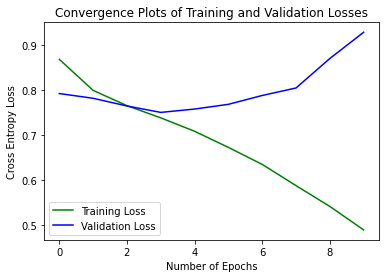

semeval-tweets/twitter-dev-data.txt (LSTM): 0.627


In [ ]:
train_model(model_lstm, criterion_lstm, optimizer_lstm, num_epochs=10)

## BERT finetuning

Finally we finetune a pre-trained BERT and perform fintuning on our downstream.

In [ ]:
#Preprocessing for Distil-BERT
def bert_preprocess(X):

    #Remove url
    X_temp = [re.sub('https?:\/\/\S+|www\.(\w+\.)+\S+', '', X[i]) for i in range(len(X))]
    #Remove usermention
    X_temp = [re.sub('@\S*', '', X_temp[i]) for i in range(len(X_temp))]
    #Remove hashtag
    X_temp = [re.sub('#\S*', '', X_temp[i]) for i in range(len(X_temp))]

    return X_temp

In [ ]:
#Just do the simplest preprecessing 
X_train_bert = bert_preprocess(X_train)
X_val_bert = bert_preprocess(X_val)

In [ ]:
#BERT Tokenizer
bert_tokenizer = transformers.BertTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
#BERT dataset

class BERTDataset(Dataset):
    def __init__(self, data, target, tokenizer, max_length=100):
        self.data = data
        self.target = target
        self.max_length = max_length
        self.tokenizer = tokenizer

    def __getitem__(self, idx):
        
        text = self.data[idx]
        
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            padding='max_length',
            add_special_tokens=True,
            return_attention_mask=True,
            max_length=self.max_length,
            return_token_type_ids=True,
            truncation=True
        )

        ids = inputs["input_ids"]
        token_type_ids = inputs["token_type_ids"]
        mask = inputs["attention_mask"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'target': torch.tensor(self.target[idx], dtype=torch.long)
            }

    def __len__(self):
        return len(self.data)

In [ ]:
#Create BERT datasets 
train_dataset_bert = BERTDataset(X_train_bert, y_train, bert_tokenizer, max_length=100)
val_dataset_bert = BERTDataset(X_val_bert, y_val, bert_tokenizer, max_length=100)

#Create Dataloaders 
train_dataloader_bert = DataLoader(train_dataset_bert, batch_size=32, shuffle=True)
val_dataloader_bert = DataLoader(val_dataset_bert, batch_size=2000)

In [ ]:
#Define the model class for BERT

class BERT(nn.Module):
    def __init__(self):
        super(BERT, self).__init__()
        self.bert_model = transformers.BertModel.from_pretrained("bert-base-uncased")
        self.fc = nn.Linear(768, 3)
        
    def forward(self,ids,mask,token_type_ids):
        _, bert_output= self.bert_model(ids,attention_mask=mask,token_type_ids=token_type_ids, return_dict=False)
        output = self.fc(bert_output)

        return output

In [ ]:
#Train on GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Instantiate model
model_bert = BERT().to(device)

#Cross Entropy Loss
criterion_bert = nn.CrossEntropyLoss()

#Initialize Optimizer
optimizer_bert = torch.optim.Adam(model_bert.parameters(), lr=0.0002)

#Freeze half of the BERT layers
ct = 0
for child in model_bert.bert_model.children():
    ct += 1
    if ct < 8:
        for param in child.parameters():
            param.requires_grad = False


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#Define dictionaries to ease access of dataloaders and dataset sizes

dataloaders = {"train": train_dataloader_bert,
               "val": val_dataloader_bert}

dataset_sizes = {"train": len(X_train_bert),
                 "val": len(X_val_bert)}

In [ ]:
#Finetune the DistilBERT model 

def finetune_bert(model, criterion, optimizer, num_epochs=10):

    #Track best accuracy
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    #Track the losses for convergence plots
    train_loss = []
    val_loss = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        #Train and validation phase for each epoch
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  #Training mode
            else:
                model.eval()   #Evaluate mode

            running_loss = 0.0
            running_corrects = 0

            #Iterate over data
            for dl in dataloaders[phase]:

                #Retrieve data information from batch
                ids=dl['ids'].to(device)
                token_type_ids=dl['token_type_ids'].to(device)
                mask= dl['mask'].to(device)
                label=dl['target'].to(device)

                #Zero out the gradients before the forward pass
                optimizer.zero_grad()


                #Forward pass only gradient enabled only when training
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, label)

                    #Backprop and optimizing step
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                #Track loss
                running_loss += loss.item() * ids.size(0)
                running_corrects += torch.sum(preds == label.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                train_loss.append(epoch_loss)
            elif phase == 'val':
                val_loss.append(epoch_loss)
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Copy the best model 
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Best val Acc: {best_acc:4f}')

    #Plot the convergence plots of the losses
    plt.plot(np.array(train_loss), color='green', label='Training Loss')
    plt.plot(np.array(val_loss), color='blue', label='Validation Loss')
    plt.legend(loc='best')
    plt.title("Convergence Plots of Training and Validation Losses")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Cross Entropy Loss")
    plt.show()

    #Save the best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model, "BERT")
    
    #Evaluate on validation set
    model.eval() 
    for dl in dataloaders['val']:

        #Retrieve data information from batch
        ids=dl['ids'].to(device)
        token_type_ids=dl['token_type_ids'].to(device)
        mask= dl['mask'].to(device)
        label=dl['target'].to(device)

        #Zero out the gradients before the forward pass
        optimizer.zero_grad()
        outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids)
        _, preds = torch.max(outputs, 1)
        preds = Encoder.inverse_transform(preds.cpu().numpy())

        #Zip the two lists of ids and our predictions into a single dictionary for evaludation
        id_preds = {tweetids['twitter-dev-data.txt'][i]: preds[i] for i in range(len(preds))}
    
        #Evaluate on the macro-F1
        evaluate(id_preds, "semeval-tweets/twitter-dev-data.txt", "BERT")

Epoch 1/25
----------
train Loss: 0.9729 Acc: 0.5198
val Loss: 0.9246 Acc: 0.5545
Epoch 2/25
----------
train Loss: 0.9124 Acc: 0.5610
val Loss: 0.8893 Acc: 0.5675
Epoch 3/25
----------
train Loss: 0.8905 Acc: 0.5722
val Loss: 0.8756 Acc: 0.5665
Epoch 4/25
----------
train Loss: 0.8753 Acc: 0.5798
val Loss: 0.8542 Acc: 0.5935
Epoch 5/25
----------
train Loss: 0.8656 Acc: 0.5866
val Loss: 0.8525 Acc: 0.5855
Epoch 6/25
----------
train Loss: 0.8559 Acc: 0.5928
val Loss: 0.8389 Acc: 0.5955
Epoch 7/25
----------
train Loss: 0.8504 Acc: 0.5946
val Loss: 0.8287 Acc: 0.6035
Epoch 8/25
----------
train Loss: 0.8440 Acc: 0.6004
val Loss: 0.8274 Acc: 0.6015
Epoch 9/25
----------
train Loss: 0.8426 Acc: 0.6003
val Loss: 0.8243 Acc: 0.6015
Epoch 10/25
----------
train Loss: 0.8382 Acc: 0.6036
val Loss: 0.8210 Acc: 0.6045
Epoch 11/25
----------
train Loss: 0.8352 Acc: 0.6020
val Loss: 0.8140 Acc: 0.6110
Epoch 12/25
----------
train Loss: 0.8328 Acc: 0.6056
val Loss: 0.8132 Acc: 0.6095
Epoch 13/25
-

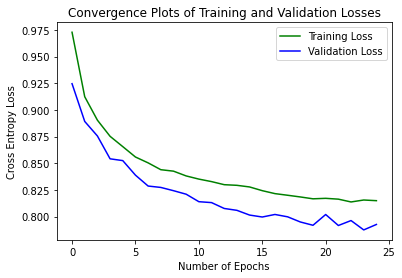

semeval-tweets/twitter-dev-data.txt (BERT): 0.605


In [ ]:
finetune_bert(model_bert, criterion_bert, optimizer_bert, num_epochs=25)

#### Build sentiment classifiers
You need to create your own classifiers (at least 3 classifiers). For each classifier, you can choose between the bag-of-word features and the word-embedding-based features. Each classifier has to be evaluated over 3 test sets. Make sure your classifier produce consistent performance across the test sets. Marking will be based on the performance over all 5 test sets (2 of them are not provided to you).

In [ ]:
#Evaluate our models on test datasets

for classifier in ['Logistic Regression', 'Naive Bayes Classifier', 'KNN Classifier', 'LSTM', 'BERT']:
    for features in ['BoW', 'Sentence Embedding', "GloVe", 'BERT']:
        
        if classifier == 'Logistic Regression':
            if features == "BoW":
                model = LogisticRegression(multi_class='multinomial', max_iter=3000, random_state=42)
                tfidf_vector = TfidfVectorizer()
                X_train_tf = tfidf_vector.fit_transform(X_train_bow)
                model.fit(X_train_tf, y_train)

                print('Training ' + classifier)
                
            elif features == "Sentence Embedding":
                model = LogisticRegression(multi_class='multinomial', max_iter=3000, random_state=42)
                pretrained = SentenceTransformer('all-MiniLM-L6-v2')
                X_train_embeddings = pretrained.encode(X_train_p)
                model.fit(X_train_embeddings, y_train)

                print('Training ' + classifier)
            else:
                continue
        
        elif classifier == 'Naive Bayes Classifier':
            if features == "BoW":
                model = MultinomialNB(fit_prior=False)
                tfidf_vector = TfidfVectorizer()
                X_train_tf = tfidf_vector.fit_transform(X_train_bow)
                model.fit(X_train_tf, y_train)
                print('Training ' + classifier)
            else:
                continue
        
            
        elif classifier == 'KNN Classifier':
            if features == "BoW":
                model = KNeighborsClassifier(n_neighbors=20)
                tfidf_vector = TfidfVectorizer()
                X_train_tf = tfidf_vector.fit_transform(X_train_bow)
                model.fit(X_train_tf, y_train)
                print('Training ' + classifier)

            elif features == "Sentence Embedding":
                model = KNeighborsClassifier(n_neighbors=20)
                pretrained = SentenceTransformer('all-MiniLM-L6-v2')
                X_train_embeddings = pretrained.encode(X_train_p)
                model.fit(X_train_embeddings, y_train)
                print('Training ' + classifier)
            else:
                continue
        
        elif classifier == 'LSTM':
            if features == 'GloVe':
                #Run this line of code if model is not downloaded
                # train_model(model_lstm, criterion_lstm, optimizer_lstm, num_epochs=10)
                model = torch.load("LSTM")
                print('Training ' + classifier)
            else:
                continue
        
        elif classifier == 'BERT':
            if features == "BERT":
                #Run this line of code if model is not downloaded
                # finetune_bert(model_bert, criterion_bert, optimizer_bert, num_epochs=15)
                model = torch.load("BERT")
                print('Training ' + classifier)
            else:
                continue

        else:
            print('Unknown classifier name' + classifier)
            continue

        # Predition performance of the classifiers
        for testset in testsets:
            if features == "Sentence Embedding":
                X_test_embedding = pretrained.encode(sentence_preprocess(tweets[testset]))
                pred = model.predict(X_test_embedding)
                pred = Encoder.inverse_transform(pred)
                
                #Make predictions on our developing data and transform it back to the original label
                id_preds = {tweetids[testset][i]: pred[i] for i in range(len(pred))}

                testset_name = testset
                testset_path = join('semeval-tweets', testset_name)
                evaluate(id_preds, testset_path, features + '-' + classifier)
            
            elif features == "BoW":
                X_test_bow = tfidf_vector.transform(sentence_preprocess(tweets[testset]))
                pred = model.predict(X_test_bow)
                pred = Encoder.inverse_transform(pred)
                
                #Make predictions on our developing data and transform it back to the original label
                id_preds = {tweetids[testset][i]: pred[i] for i in range(len(pred))}

                testset_name = testset
                testset_path = join('semeval-tweets', testset_name)
                evaluate(id_preds, testset_path, features + '-' + classifier)
            
            elif features == "GloVe":
                X_test_pp = emb_preprocess(tweets[testset])
                test_data = TextDataset(X_test_pp, Encoder.transform(tweetgts[testset]))
                test_dataloader = DataLoader(test_data, batch_size=len(tweets[testset]))
                
                model.eval() 

                for inputs, labels in test_dataloader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    #Zero out the gradients before the forward pass
                    optimizer_lstm.zero_grad()
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    preds = Encoder.inverse_transform(preds.cpu().numpy())

                    #Zip the two lists of ids and our predictions into a single dictionary for evaludation
                    id_preds = {tweetids[testset][i]: preds[i] for i in range(len(preds))}

                    testset_name = testset
                    testset_path = join('semeval-tweets', testset_name)
                    evaluate(id_preds, testset_path, features + '-' + classifier)

            elif features == "BERT":
                X_test_bert = bert_preprocess(tweets[testset])
                test_data = BERTDataset(X_test_bert, Encoder.transform(tweetgts[testset]), bert_tokenizer, max_length=100) 
                test_dataloader = DataLoader(test_data, batch_size=len(tweets[testset])) 
                    
                model.eval() 

                for dl in test_dataloader:

                    #Retrieve data information from batch
                    ids=dl['ids'].to(device)
                    token_type_ids=dl['token_type_ids'].to(device)
                    mask= dl['mask'].to(device)
                    label=dl['target'].to(device)

                    #Zero out the gradients before the forward pass
                    optimizer_bert.zero_grad()
                    outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids)
                    _, preds = torch.max(outputs, 1)
                    preds = Encoder.inverse_transform(preds.cpu().numpy())

                    #Zip the two lists of ids and our predictions into a single dictionary for evaludation
                    id_preds = {tweetids[testset][i]: preds[i] for i in range(len(preds))}

                    testset_name = testset
                    testset_path = join('semeval-tweets', testset_name)
                    evaluate(id_preds, testset_path, features + '-' + classifier)

Training Logistic Regression
semeval-tweets/twitter-test1.txt (BoW-Logistic Regression): 0.467
semeval-tweets/twitter-test2.txt (BoW-Logistic Regression): 0.446
semeval-tweets/twitter-test3.txt (BoW-Logistic Regression): 0.464
Training Logistic Regression
semeval-tweets/twitter-test1.txt (Sentence Embedding-Logistic Regression): 0.569
semeval-tweets/twitter-test2.txt (Sentence Embedding-Logistic Regression): 0.594
semeval-tweets/twitter-test3.txt (Sentence Embedding-Logistic Regression): 0.565
Training Naive Bayes Classifier
semeval-tweets/twitter-test1.txt (BoW-Naive Bayes Classifier): 0.413
semeval-tweets/twitter-test2.txt (BoW-Naive Bayes Classifier): 0.421
semeval-tweets/twitter-test3.txt (BoW-Naive Bayes Classifier): 0.444
Training KNN Classifier
semeval-tweets/twitter-test1.txt (BoW-KNN Classifier): 0.237
semeval-tweets/twitter-test2.txt (BoW-KNN Classifier): 0.268
semeval-tweets/twitter-test3.txt (BoW-KNN Classifier): 0.238
Training KNN Classifier
semeval-tweets/twitter-test1.tx